In [22]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import matplotlib.gridspec as gridspec
try:
    import pcmdpy_gpu as ppy
except:
    import pcmdpy as ppy
from tqdm import tqdm
import dynesty
from seaborn import kdeplot
from dynesty import plotting as dyplot
%matplotlib inline

In [31]:
plt.style.library.keys()

dict_keys(['Solarize_Light2', 'seaborn-talk', 'fivethirtyeight', 'seaborn-whitegrid', 'bmh', 'grayscale', 'seaborn-deep', 'fast', 'seaborn-white', 'seaborn-poster', 'seaborn-bright', 'ggplot', 'seaborn-ticks', 'tableau-colorblind10', 'seaborn', 'seaborn-darkgrid', 'seaborn-muted', 'seaborn-notebook', 'classic', 'seaborn-paper', 'dark_background', '_classic_test', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-pastel', 'seaborn-colorblind', 'cook'])

In [47]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('cook')

In [37]:
from setup_files.mocks_paper1.mock_models import models, run_names

In [38]:
original_params = np.array([-0.25, -0.5, 2.0, 3.0, 26.0])

In [39]:
res = {}
for k in models.keys():
    res[k] = ppy.results.ResultsPlotter('results/paper1_{:s}.csv'.format(k), live_file='results/paper1_{:s}_live.csv'.format(k),
                                        true_model=models[k], run_name=run_names[k])

# Dynesty Weights

We need to figure out how to handle the Dynesty weighting.

When a run is completed (or it ends early, and we keep the live points), we find that the last handful of points (often only 1 point) have nearly all the weight.

In [40]:
r = res['mock_5']

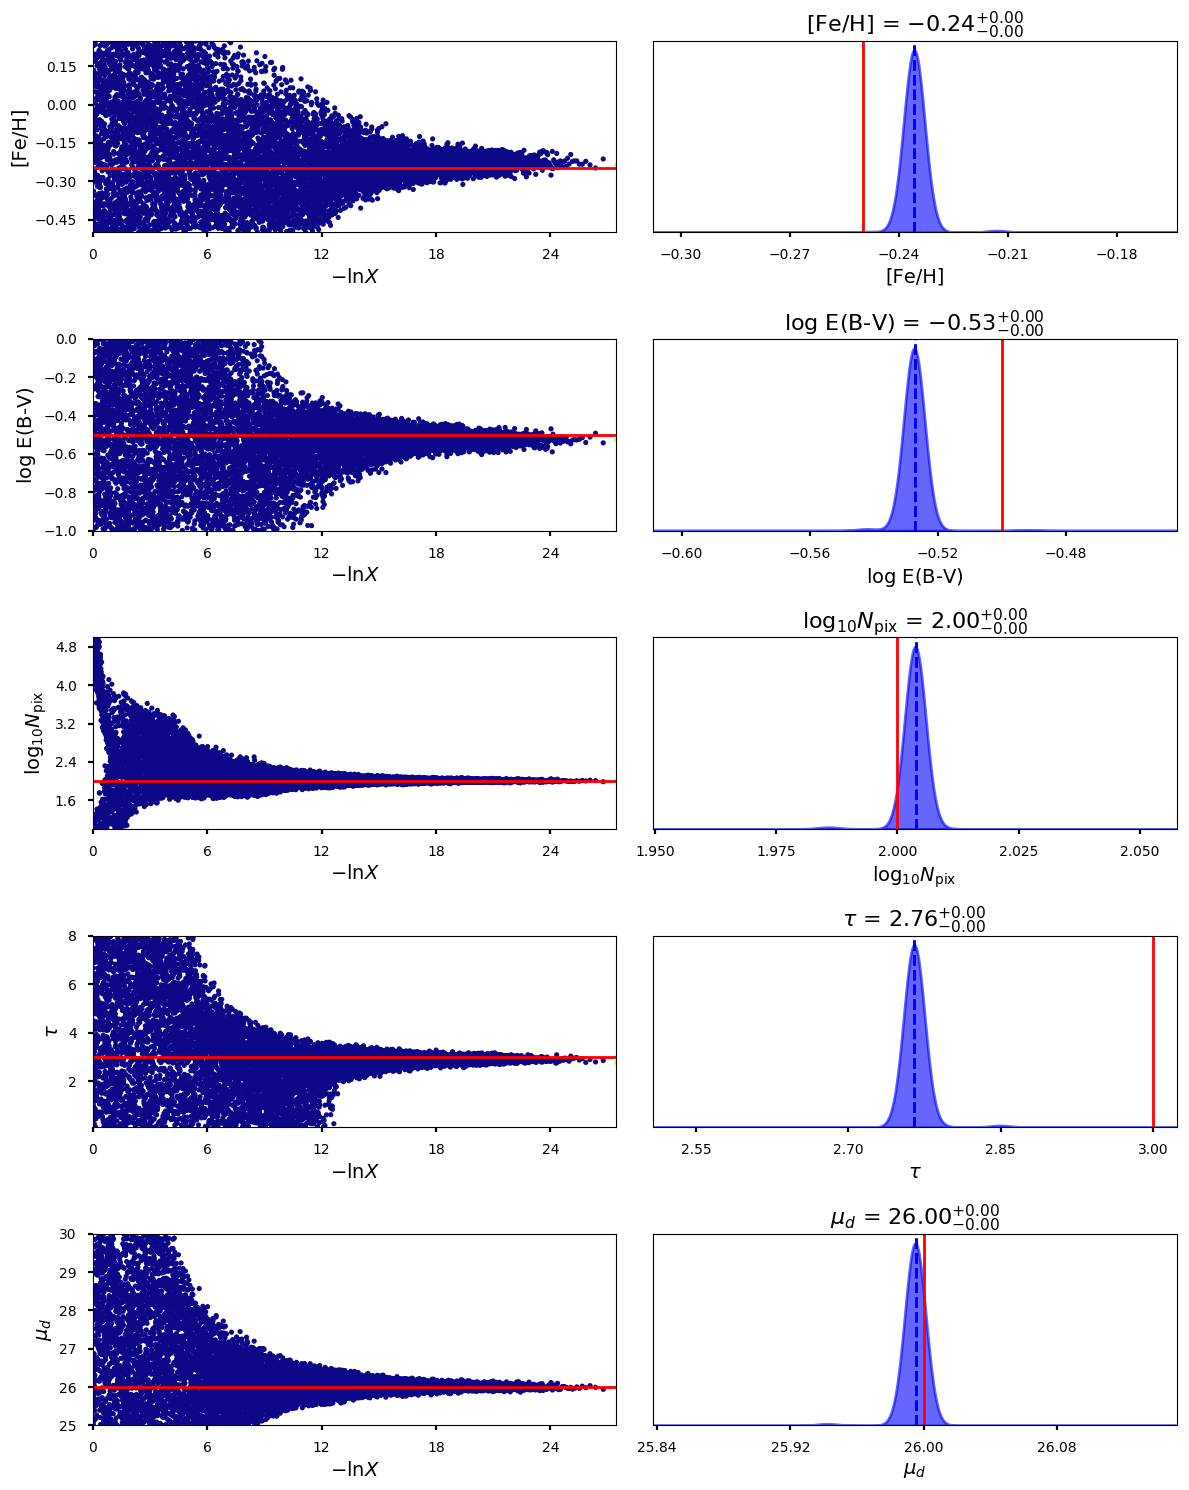

In [48]:
r.plot_trace();
plt.tight_layout()

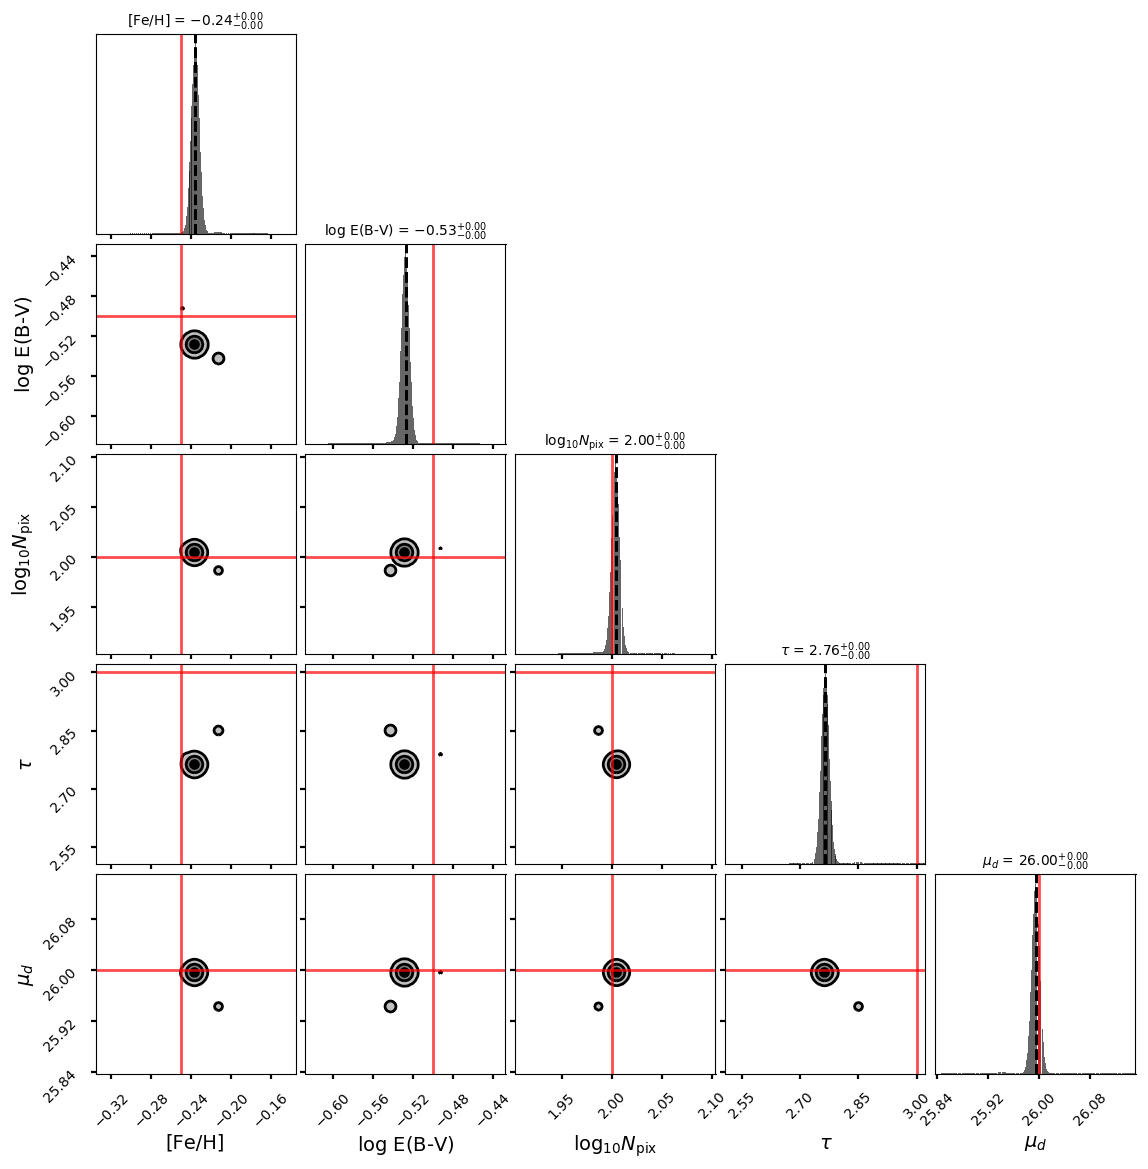

In [49]:
fig, axes = r.plot_corner();
for a in axes.flatten():
    a.title.set_fontsize(10)

In [50]:
r.get_weights()

array([0.        , 0.        , 0.        , ..., 0.00382135, 0.00897078,
       0.98717908])

Text(0.5,1,'Mock 5')

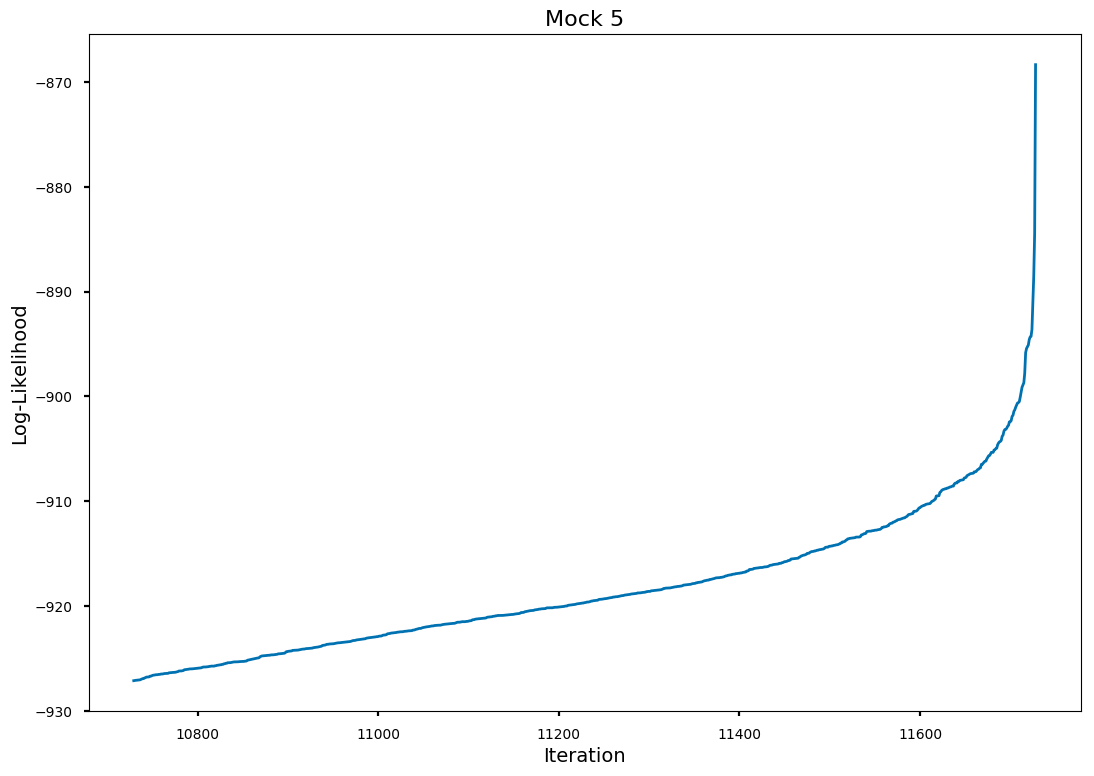

In [51]:
plt.plot(res['mock_5'].df.logl[-1000:])
plt.ylabel('Log-Likelihood')
plt.xlabel('Iteration')
plt.title('Mock 5')

Nearly every mock run exhibits the same behavior by the time it completes

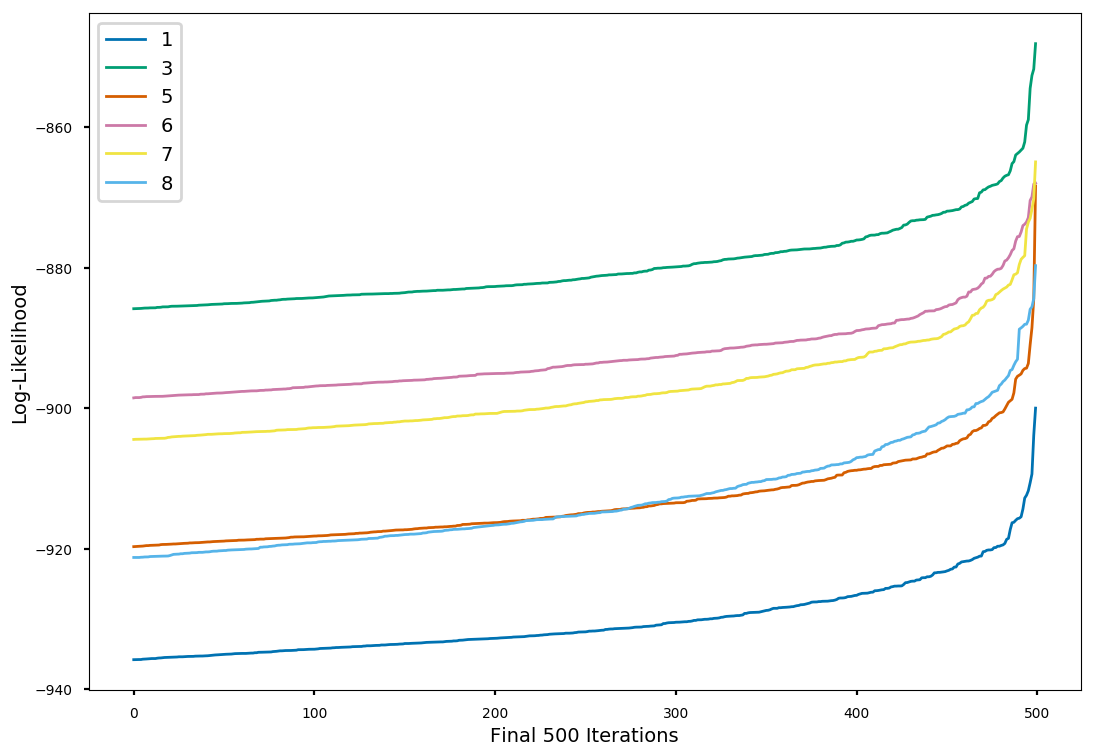

In [52]:
for i in [1, 3, 5, 6, 7, 8]:
    k = f'mock_{i}'
    r = res[k]
    y = np.array(r.df.logl[-500:].values)
    plt.plot(y, label=i)
plt.ylabel('Log-Likelihood')
plt.xlabel('Final 500 Iterations')
plt.legend(loc=0)

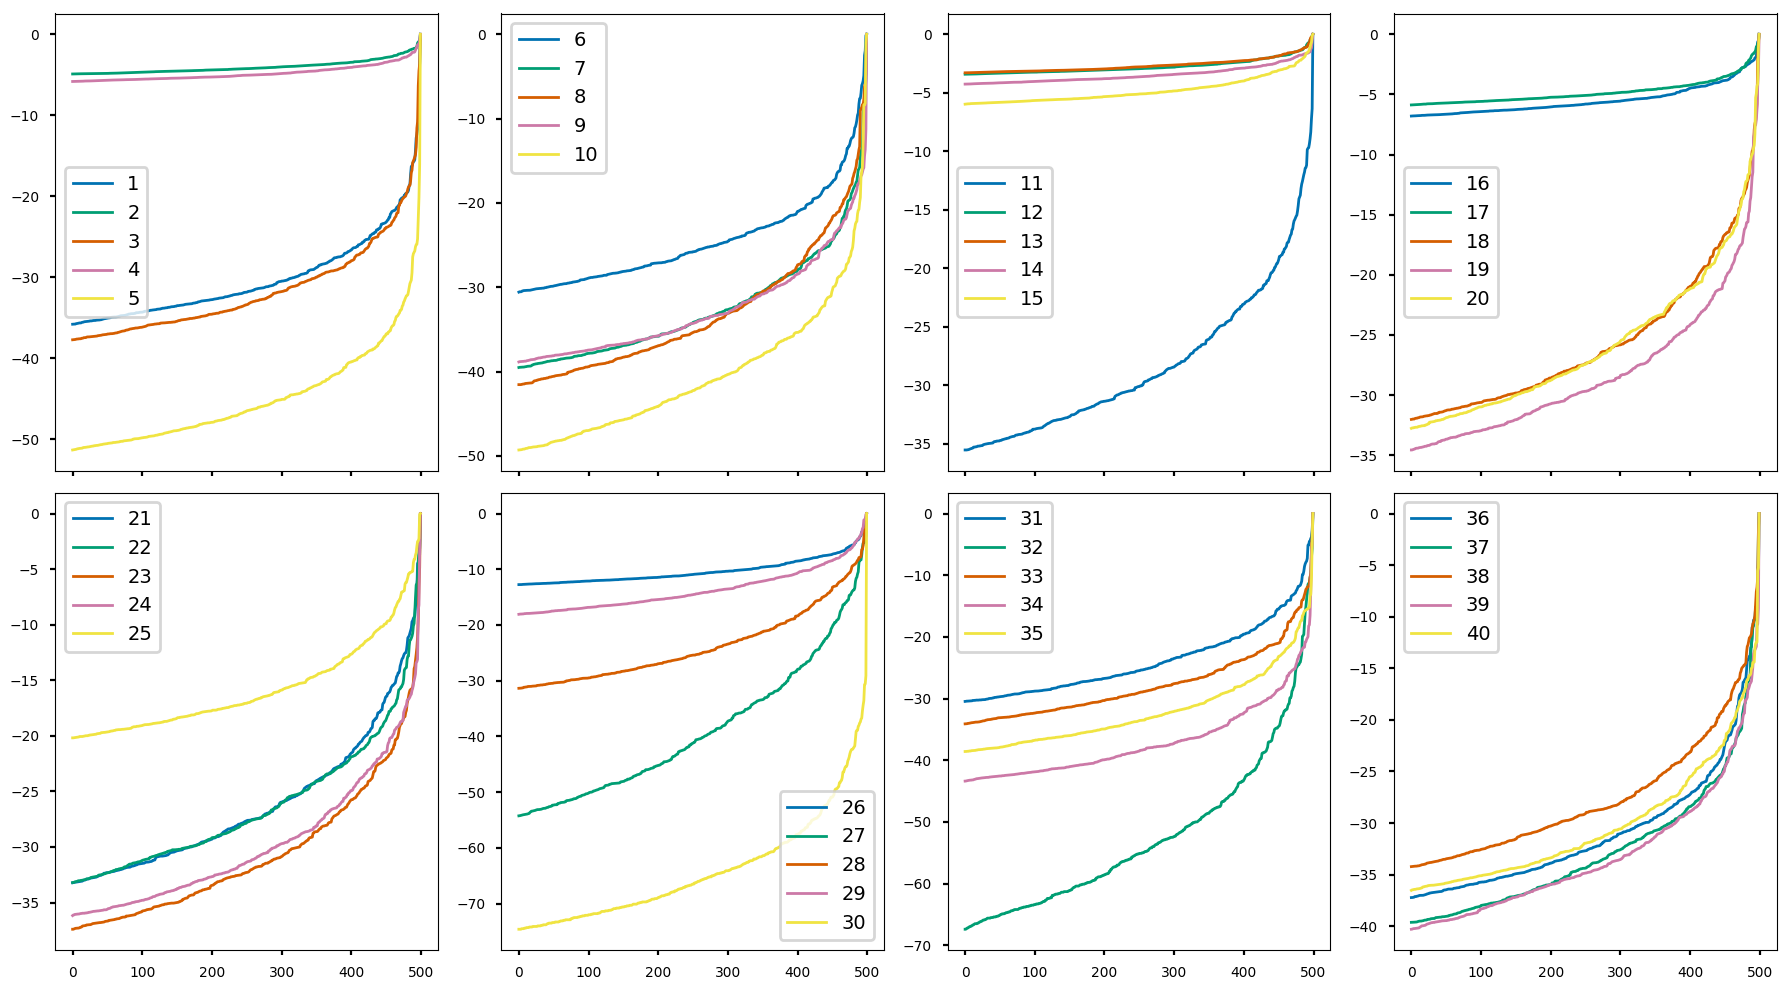

In [53]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(18, 10), sharex=True)
axes = axes.flatten()
for i in range(1, 41):
    a = axes[(i-1)//5]
    k = f'mock_{i}'
    r = res[k]
    y = np.array(r.df.logl[-500:].values)
    y -= y.max()
    a.plot(y, label=i)
    a.legend(loc=0)
plt.tight_layout()

Our hypothesis is that this is due to the Stochastic nature of the likelihood calls... The final Dynesty points are rare, positive fluctuations in Likelihood space, and so we shouldn't trust their values fully.

We could potentially trim the final $N$ Dynesty points. Let's look at how that would affect our parameter estimates:

Text(0.5,0,'Final Points Trimmed')

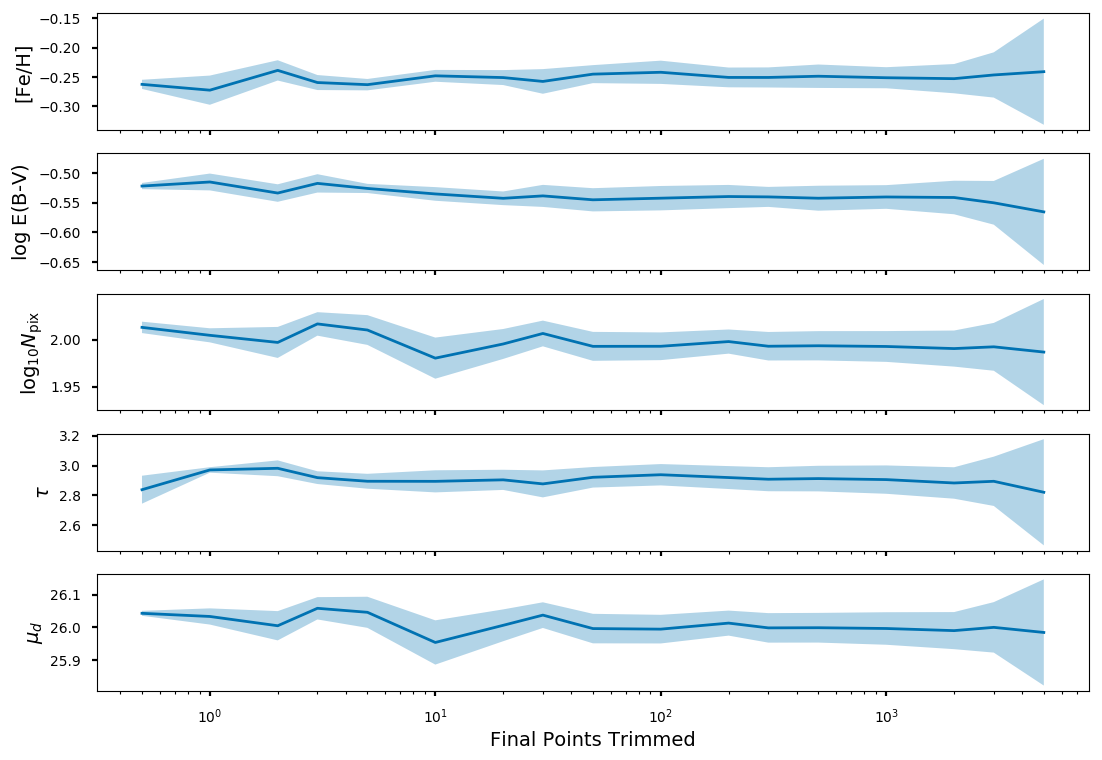

In [54]:
trims = [0, 1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000]
means = np.array([res['mock_5'].means(trim=t) for t in trims]).T
stds = np.array([res['mock_5'].stds(trim=t) for t in trims]).T

trims[0] = 0.5
fig, axes = plt.subplots(nrows=5, sharex=True)
for i, a in enumerate(axes):
    a.plot(trims, means[i])
    a.fill_between(trims, y1=means[i]-stds[i], y2=means[i]+stds[i], alpha=0.3)
    a.set_ylabel(res['mock_5'].labels[i])
    a.set_xscale('log')
axes[-1].set_xlabel('Final Points Trimmed')

The errors on the parameters appears to be underestimated until we trim the first dozen or so points.

So, we propose one of two approaches for handling the results of the Dynesty runs

First, identify a criterion to determine when the Log-Likelihoods are untrustworthy

Then, either:

* Remove all Dynesty points past that point (ex: the final $\sim 200$ points)

* Or, downweight their weights, perhaps as if they had constant $\mathcal{L}$


# Confirm Likelihood Bias

Let's confirm our suspicions by re-sampling the Likelihoods

In [14]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f, mag_system='ab')

In [15]:
if not ppy.gpu_utils._GPU_ACTIVE:
    import pcmdpy_gpu as ppy
assert ppy.gpu_utils._GPU_ACTIVE
driv = ppy.driver.Driver(iso_model, gpu=True)

Please wait while the GPU states are initialized

In [16]:
gal = models['mock_5']
gal.set_params(original_params)

In [17]:
pcmd_data, _ = driv.simulate(gal, 256, fixed_seed=True, mag_system='ab')

In [18]:
magbins = np.arange(10, 45, 0.05)
colorbins = np.arange(-1.5, 5.6, 0.05)  # fairly insensitive to distance
bins = [magbins, colorbins]

In [19]:
driv.initialize_data(pcmd_data, bins=bins)

In [20]:
lls_exact = []
for _ in tqdm(range(200)):
    pcmd, _ = driv.simulate(gal, 512, fixed_seed=False, mag_system='ab')
    lls_exact.append(driv.loglike(pcmd))
lls_exact = np.array(lls_exact)

100%|██████████| 200/200 [08:19<00:00,  2.50s/it]


Text(0.5,1,'Reruns of True Model')

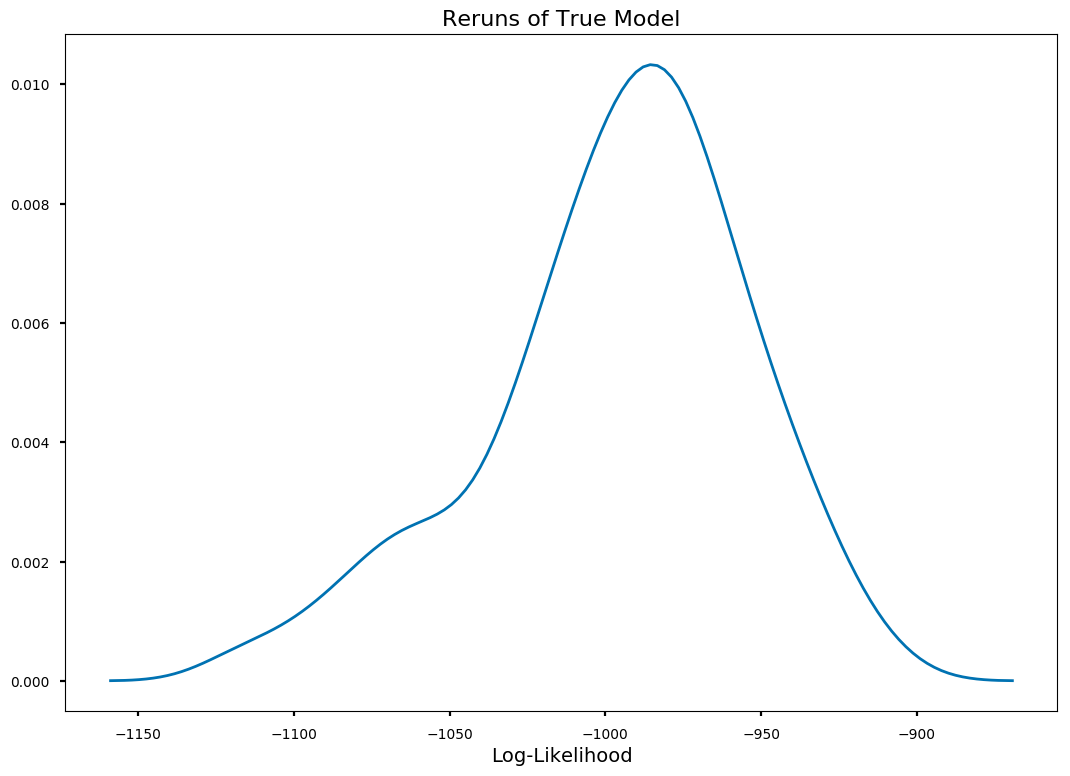

In [55]:
kdeplot(lls_exact)
plt.xlabel('Log-Likelihood')
plt.title('Reruns of True Model')

In [134]:
resample_ids = [-1, -2, -3, -4, -5, -10, -20, -30, -40, -50, -100, -200, -300, -400, -500, -1000, -2000, -3000, -4000, -5000]

In [136]:
lls = []
for i in tqdm(resample_ids):
    p = res['mock_5'].get_samples()[i]
    gal.set_params(p)
    this_ll = []
    for j in range(5):
        pcmd, _ = driv.simulate(gal, 512, fixed_seed=False, mag_system='ab')
        this_ll.append(driv.loglike(pcmd))
    lls.append(this_ll)

100%|██████████| 20/20 [04:46<00:00, 15.49s/it]


In [138]:
lls = np.array([np.array(l) for l in lls])

In [147]:
c = plt.rcParams['axes.prop_cycle']

In [155]:
list(c)[0]

{'color': '#0072b2', 'linestyle': '-'}

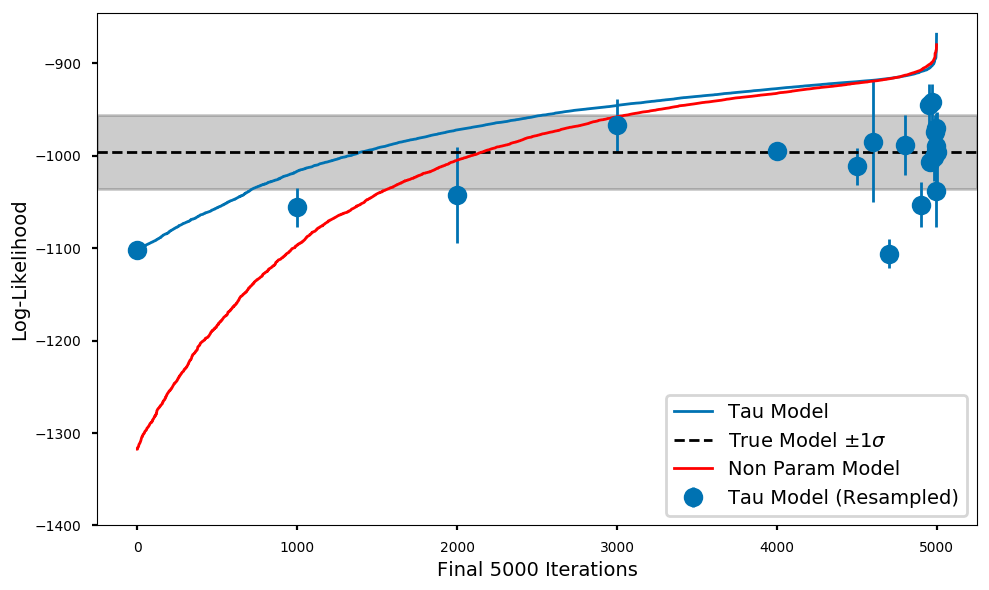

In [157]:
trim = 5000
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(trim)
ax.plot(x, res['mock_5'].df.logl[-trim:].values, label='Tau Model')
xs = np.array(resample_ids) + trim
ys = np.mean(lls, axis=-1)
yerrs = np.std(lls, axis=-1)
ax.errorbar(xs, y=ys, yerr=yerrs, label='Tau Model (Resampled)', marker='o', ls='',
            color=list(plt.rcParams['axes.prop_cycle'])[0]['color'])
ax.axhspan(np.percentile(lls_exact, 16), np.percentile(lls_exact, 84.), alpha=0.2, color='k')
ax.axhline(np.mean(lls_exact), ls='--', color='k', label=r'True Model $\pm 1 \sigma$')

ax.plot(x, res['mock_8'].df.logl[-trim:].values, label='Non Param Model', color='r')
ax.set_ylim(ymin=-1400)

ax.set_ylabel('Log-Likelihood')
ax.set_xlabel(f'Final {trim} Iterations')
ax.legend(loc=0)
plt.tight_layout()

Text(0,0.5,'Distance from True Result')

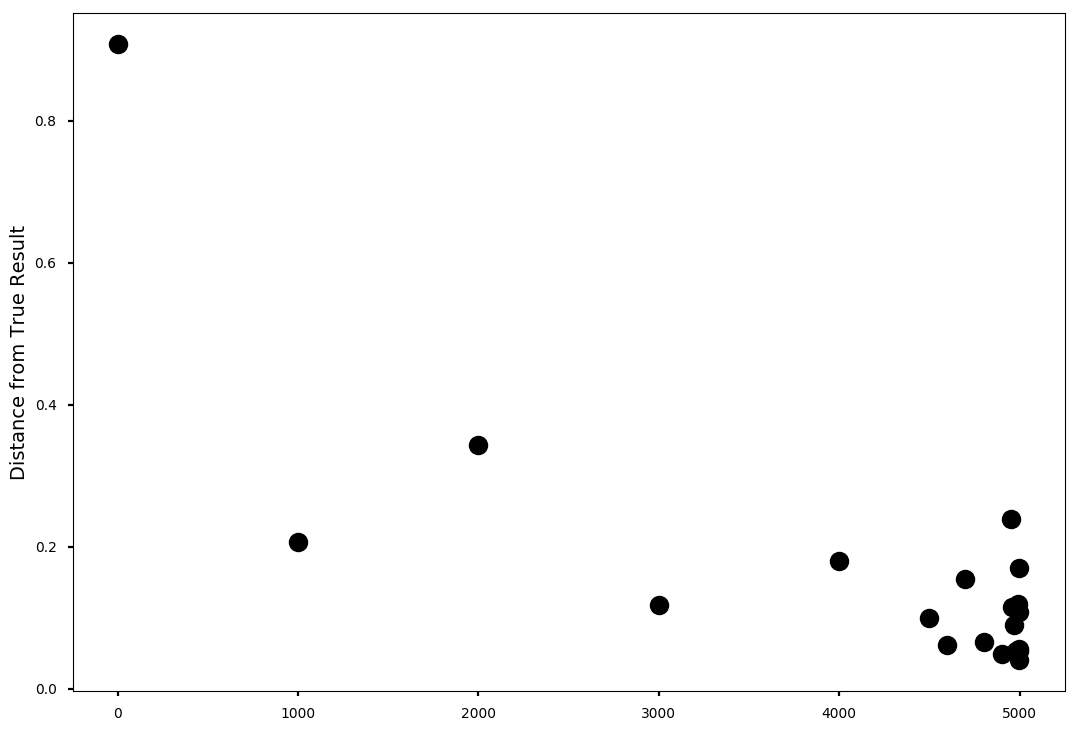

In [159]:
D_result = np.sqrt(((np.array([res['mock_5'].get_samples()[i] for i in resample_ids]) - res['mock_5'].true_params)**2).sum(axis=-1))
plt.plot(xs, D_result, 'ko')
plt.ylabel('Distance from True Result')

Text(0,0.5,'Resimulated Log-Likelihood')

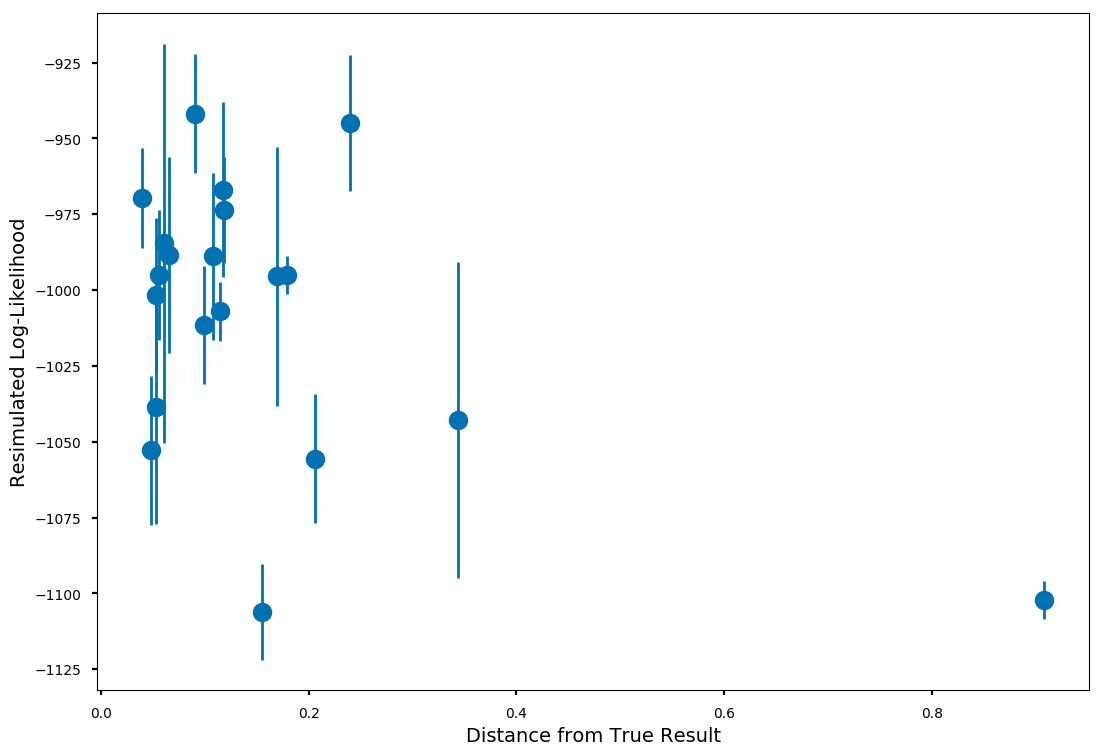

In [160]:
plt.errorbar(D_result, y=np.mean(lls, axis=-1), yerr=np.std(lls, axis=-1), marker='o', ls='')
plt.xlabel('Distance from True Result')
plt.ylabel('Resimulated Log-Likelihood')

# Resimulating Dynesty Runs

In [161]:
r = res['mock_5']
cutoff = -1000.

/n/home01/bcook/dynesty/dynesty/utils.py:679: RuntimeWarning: invalid value encountered in sqrt
  new_res.logzerr = np.sqrt(np.array(saved_logzvar))


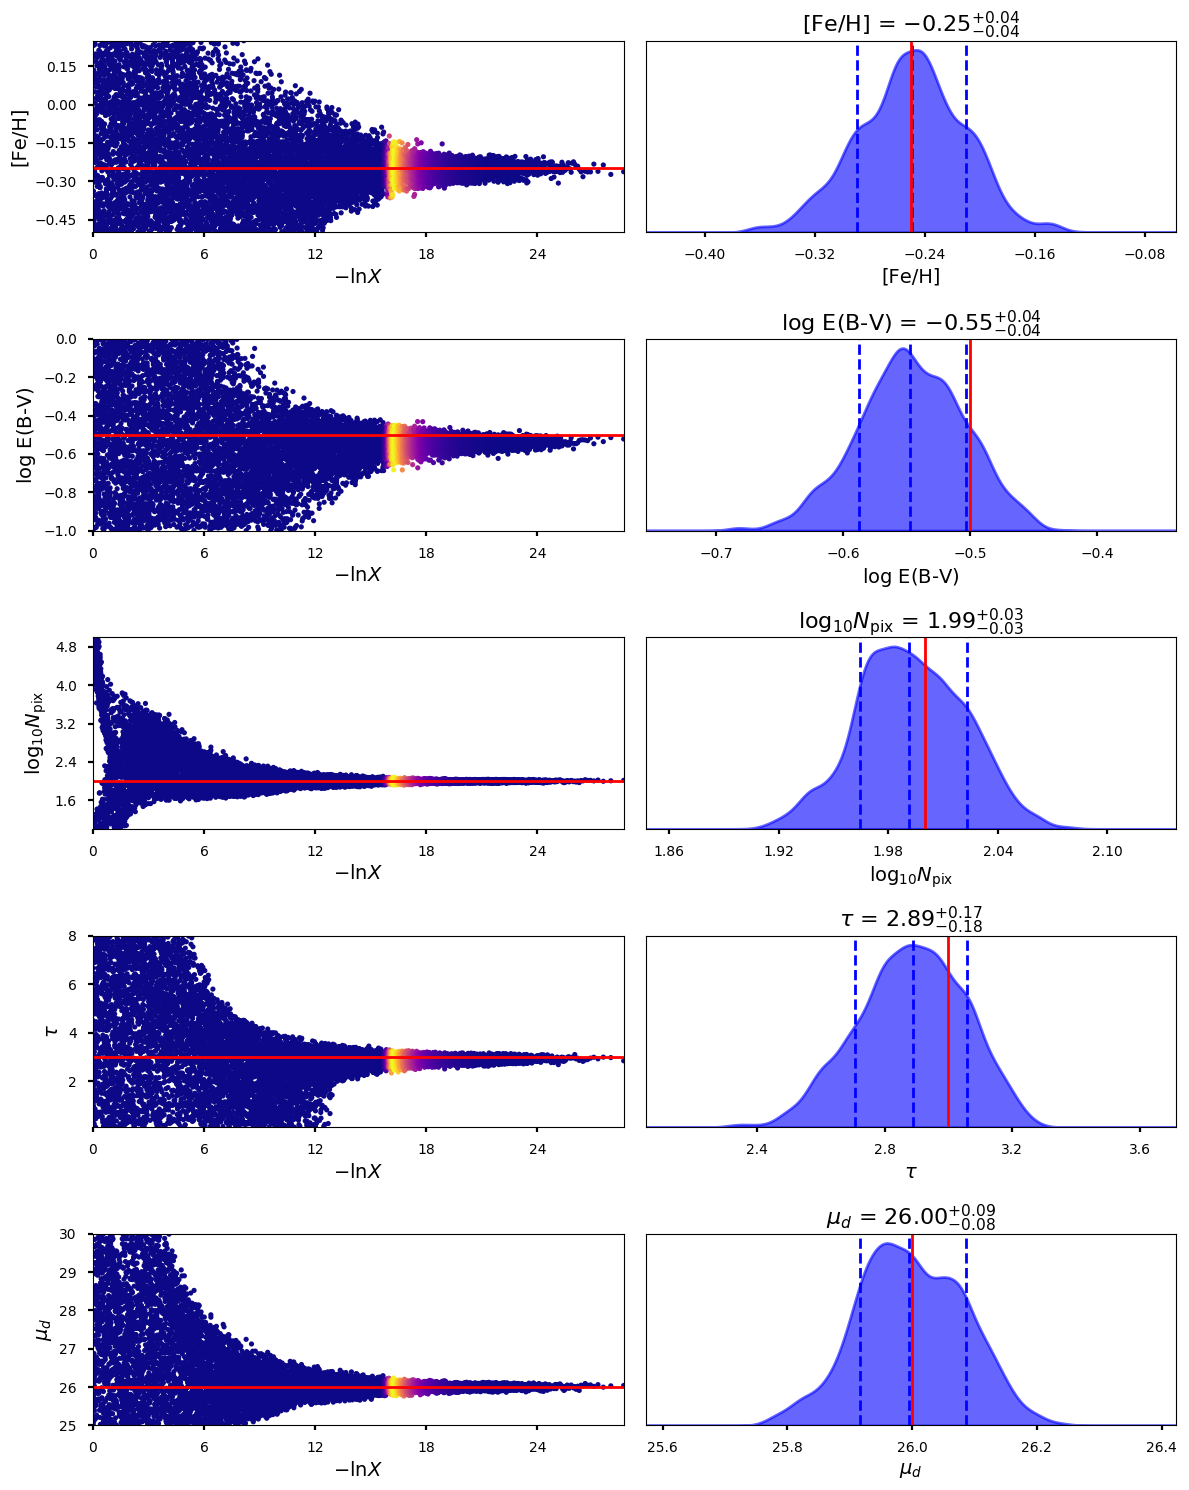

In [162]:
r.plot_trace(max_logl=cutoff);
plt.tight_layout()

/n/home01/bcook/dynesty/dynesty/utils.py:679: RuntimeWarning: invalid value encountered in sqrt
  new_res.logzerr = np.sqrt(np.array(saved_logzvar))


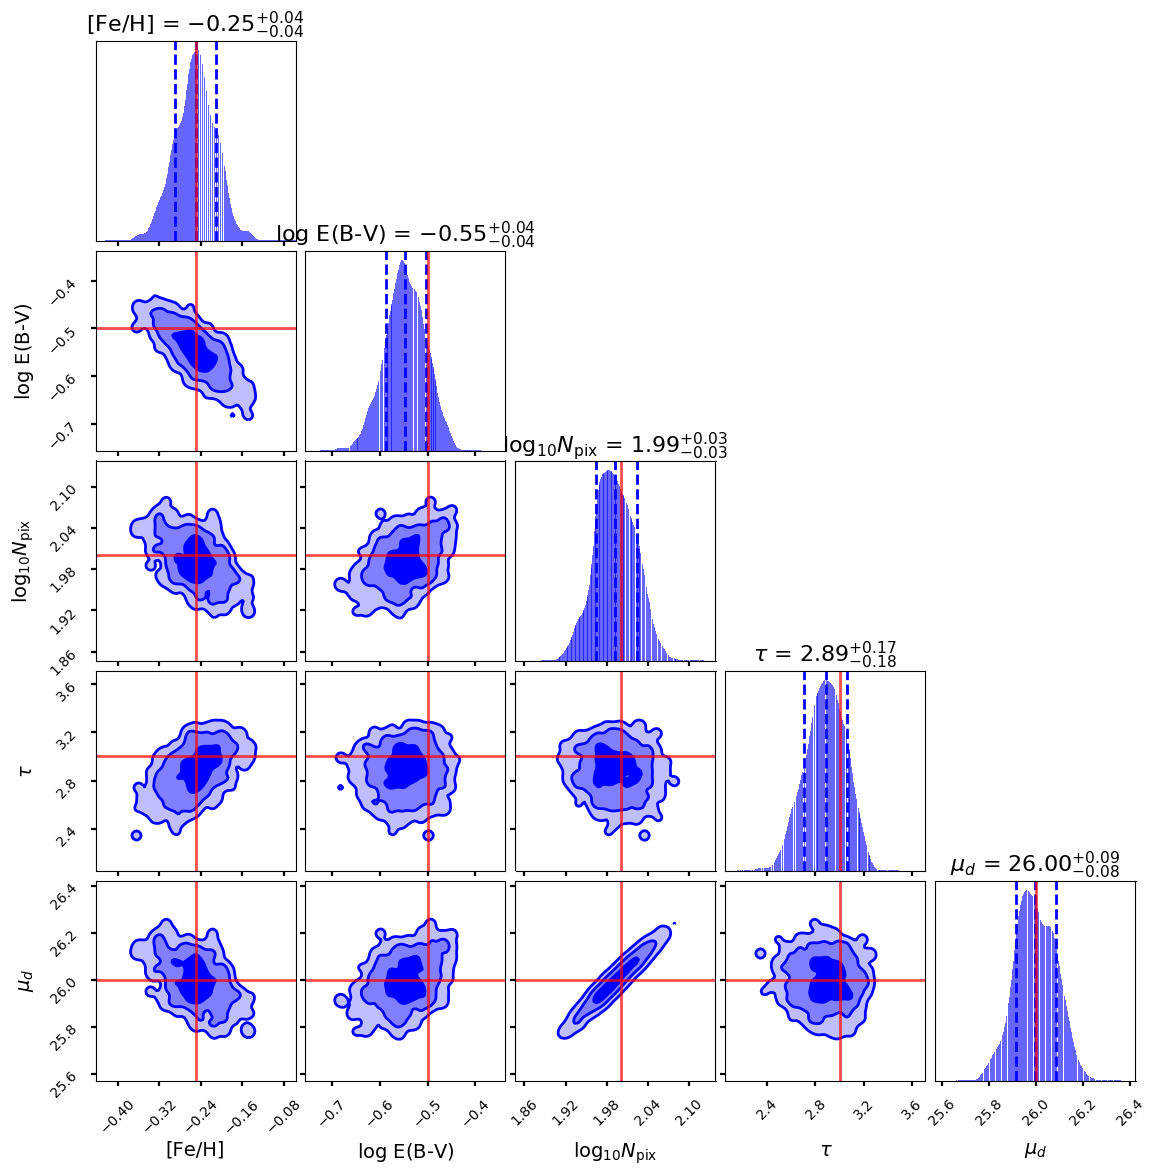

In [163]:
fig, axes = r.plot_corner(max_logl=cutoff, smooth=0.02, show_titles=True, color='b');
for a in axes.flatten():
    a.tick_params(axis='both', which='major', labelsize=10)

/n/home01/bcook/dynesty/dynesty/utils.py:679: RuntimeWarning: invalid value encountered in sqrt
  new_res.logzerr = np.sqrt(np.array(saved_logzvar))


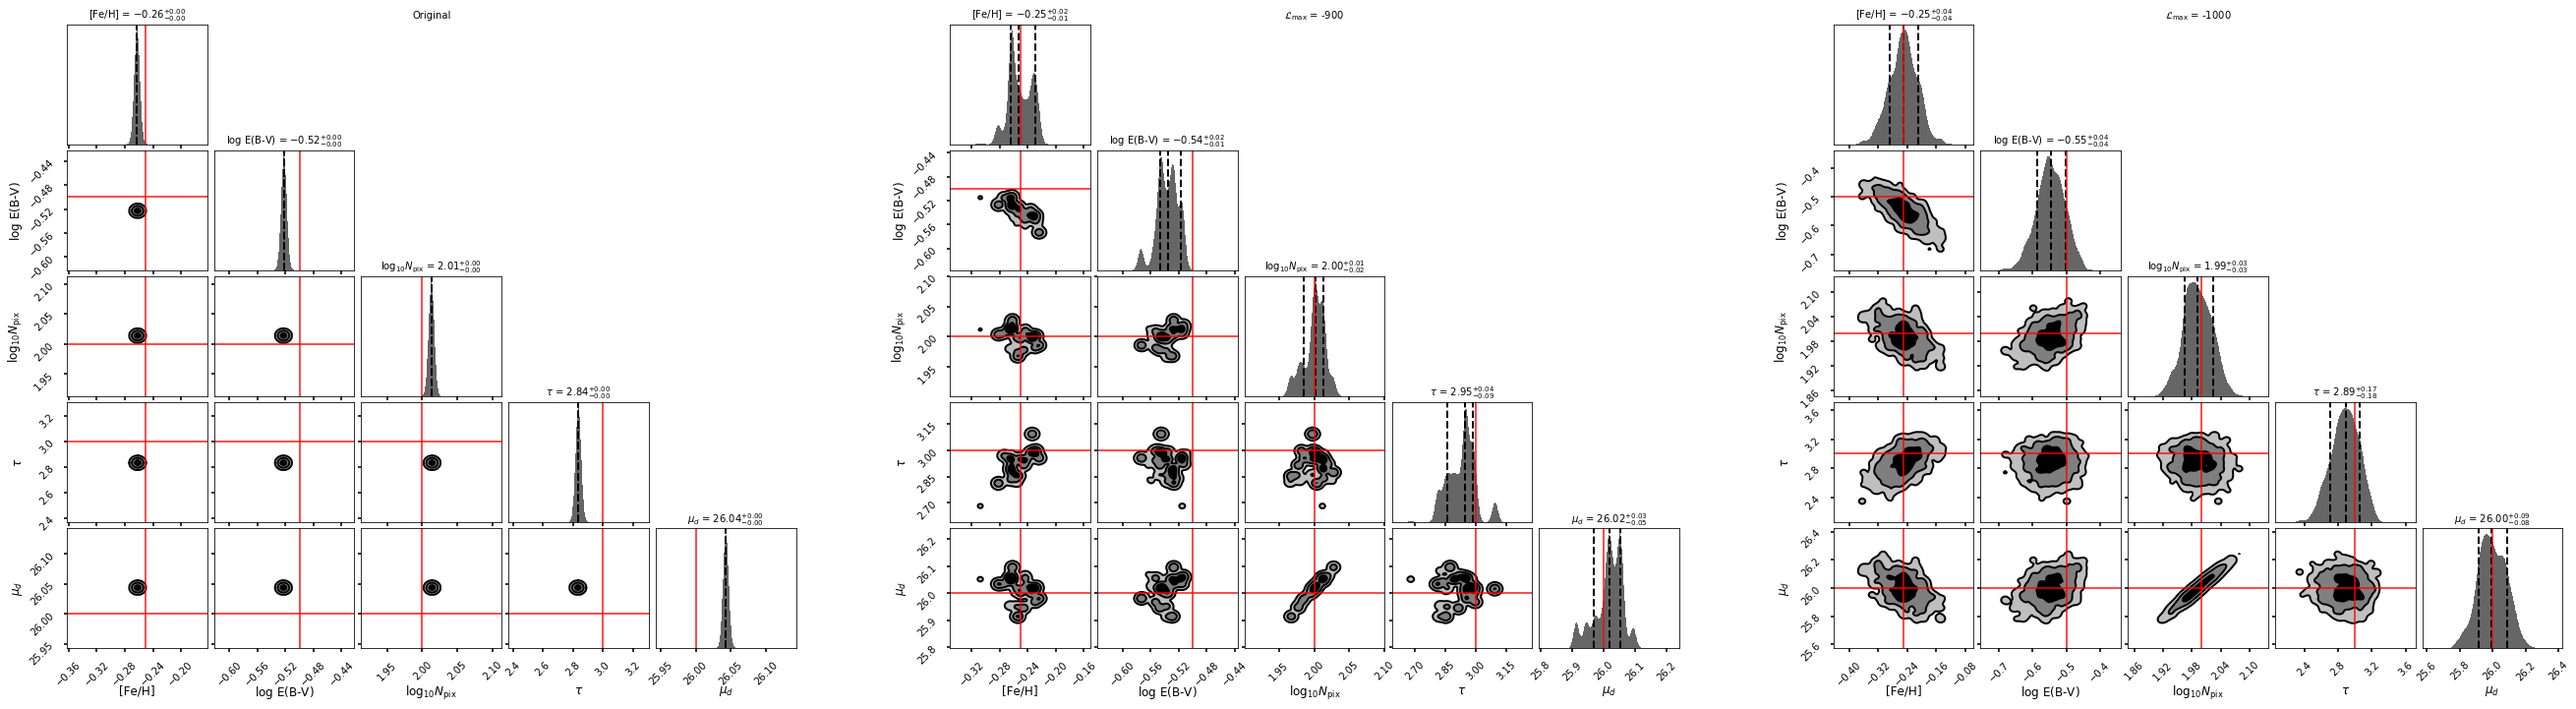

In [28]:
fig, axes = plt.subplots(ncols=17, nrows=5, figsize=(40, 10))
r.plot_corner(max_logl=None, axes=axes[:, :5]);
axes[0, 2].set_title('Original')
r.plot_corner(max_logl=-900., axes=axes[:, 6:11]);
axes[0, 8].set_title(r'$\mathcal{L}_\mathrm{max}$ = -900')
r.plot_corner(max_logl=-1000., axes=axes[:, 12:]);
axes[0, 14].set_title(r'$\mathcal{L}_\mathrm{max}$ = -1000');
for a in axes.flatten():
    a.title.set_fontsize(10)
for a in list(axes[:, 5])+list(axes[:, 11]):
    a.axis('off')

# Other Experiments

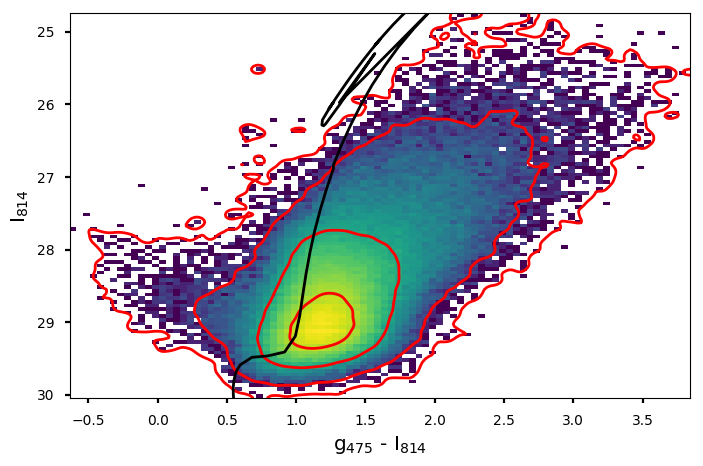

In [133]:
fig, ax = plt.subplots(figsize=(8,5))
ppy.plotting.plot_pcmd(pcmd, ax=ax)
sigs = [1, 2, 3, 4]
levels = 1.0 - np.exp(-0.5 * np.array(sigs)** 2)
dyplot._hist2d(pcmd[1], pcmd[0], ax=ax, levels=levels, smooth=.01, contour_kwargs={'alpha': 1.},
               plot_contours=True, plot_density=False, fill_contours=False, no_fill_contours=True, color='r', zorder=-1)
ppy.plotting.plot_isochrone(iso_model, dmod=26., axes=ax);